# Import Libraries

In [1]:
import nltk
import pandas as pd
import numpy as np
from sklearn import preprocessing,metrics,manifold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
# NOTE: Installed kernelspec venv in /home/kenny/.local/share/jupyter/kernels/venv
from nltk.tokenize.toktok import ToktokTokenizer
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
import string
# import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import MultinomialNB
from joblib import dump, load

[nltk_data] Downloading package stopwords to /home/kenny/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/kenny/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/kenny/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Load Dataset

In [2]:
# Read csv
imdb_dataset = pd.read_csv('IMDB_Dataset.csv') ## Dataset Without cleaning
imdb_dataset.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Dataset info

In [3]:
imdb_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


We haven't found any rows with null values 

## Dataset summary

In [4]:
imdb_dataset.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


# Number of positive and negative reviews

In [5]:
pos_reviews=imdb_dataset[imdb_dataset['sentiment']=='positive'][['review']]
print(f"First 7 samples of positive reviews: \n{pos_reviews.head(7)} \n")
neg_reviews=imdb_dataset[imdb_dataset['sentiment']=='negative'][['review']]
print(f"First 7 samples of negative reviews: \n{neg_reviews.head(7)}")

First 7 samples of positive reviews: 
                                              review
0  One of the other reviewers has mentioned that ...
1  A wonderful little production. <br /><br />The...
2  I thought this was a wonderful way to spend ti...
4  Petter Mattei's "Love in the Time of Money" is...
5  Probably my all-time favorite movie, a story o...
6  I sure would like to see a resurrection of a u...
9  If you like original gut wrenching laughter yo... 

First 7 samples of negative reviews: 
                                               review
3   Basically there's a family where a little boy ...
7   This show was an amazing, fresh & innovative i...
8   Encouraged by the positive comments about this...
10  Phil the Alien is one of those quirky films wh...
11  I saw this movie when I was about 12 when it c...
12  So im not a big fan of Boll's work but then ag...
13  The cast played Shakespeare.<br /><br />Shakes...


In [6]:
# Total count of positive and negative reviews:
print(f"Number of examples in the dataset: {len(imdb_dataset.index)}")
# https://stackoverflow.com/questions/15943769/how-do-i-get-the-row-count-of-a-pandas-dataframe
# len(df.index) is the fastest way to row count of a pandas dataframe
print(imdb_dataset['sentiment'].value_counts())

Number of examples in the dataset: 50000
positive    25000
negative    25000
Name: sentiment, dtype: int64


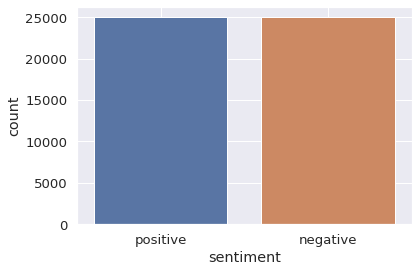

In [7]:
sns.set(style = "dark" , font_scale = 1.2)
sns.countplot(x=imdb_dataset['sentiment'])
plt.grid()

# Most used words for each type of sentiment

In [8]:
def generateWordCloud(data,title="",):
    wc = WordCloud(width = 1600, height = 800, 
                background_color ='black', 
                stopwords = set(STOPWORDS), 
                max_words=2000,
                min_font_size = 10).generate(' '.join(data)) 

    plt.figure(figsize=(8,8))
    plt.imshow(wc)
    plt.title(title)
    plt.axis('off')

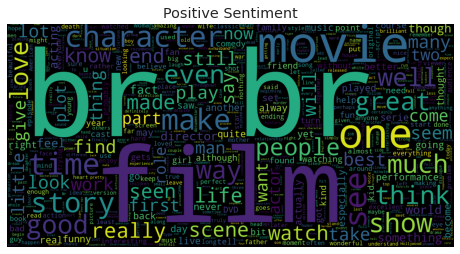

In [9]:
# Wordcloud for positive reviews
generateWordCloud(pos_reviews['review'],'Positive Sentiment')

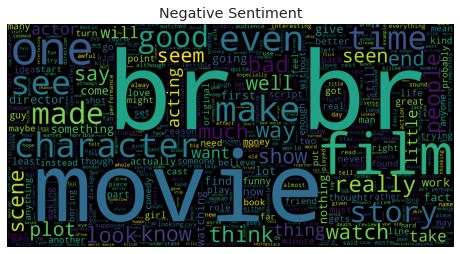

In [10]:
# Wordcloud for negative reviews
generateWordCloud(neg_reviews['review'],'Negative Sentiment')

##  Number of words in each text


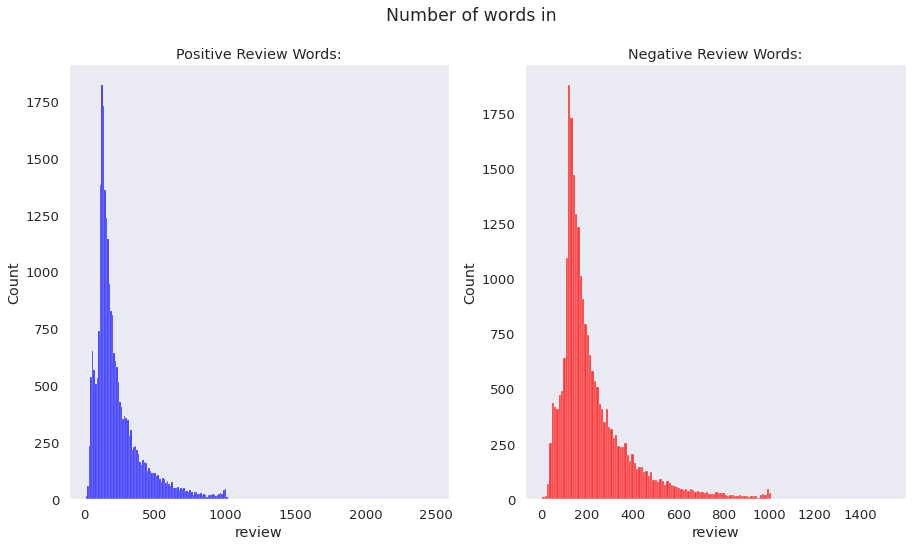

In [11]:
count_pos_words=pos_reviews['review'].str.split().apply(lambda x: len(x))
count_neg_words=neg_reviews['review'].str.split().apply(lambda x: len(x))

# print(f"Positive Review Words: \n{count_pos_words} \n")
# print(f"Negative Review Words: \n{count_neg_words}")
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
sns.histplot(count_pos_words,color='blue')
plt.title("Positive Review Words:")
plt.subplot(1, 2, 2)
sns.histplot(count_neg_words,color='red')
plt.title("Negative Review Words:")
plt.suptitle("Number of words in ")
plt.show()

## Data cleaning

In [12]:
# Dataset before cleaning
imdb_dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [13]:
def removeHtml(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

imdb_dataset['review'] = imdb_dataset['review'].apply(removeHtml)
imdb_dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. The filming tec...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [14]:
def removePunct(text):
    #https://stackoverflow.com/questions/34293875/how-to-remove-punctuation-marks-from-a-string-in-python-3-x-using-translate
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)
imdb_dataset['review'] = imdb_dataset['review'].apply(removePunct)
imdb_dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production The filming tech...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically theres a family where a little boy J...,negative
4,Petter Matteis Love in the Time of Money is a ...,positive


In [15]:
def removeUrl(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

imdb_dataset['review'] = imdb_dataset['review'].apply(removeUrl)
imdb_dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production The filming tech...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically theres a family where a little boy J...,negative
4,Petter Matteis Love in the Time of Money is a ...,positive


In [16]:
def removeEmojis(text):
    #https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
    pattern = re.compile("["
                       u"\U0001F600-\U0001F64F"  # emoticons
                       u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                       u"\U0001F680-\U0001F6FF"  # transport & map symbols
                       u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                       u"\U00002702-\U000027B0"
                       u"\U000024C2-\U0001F251"
                       u"\U0001f926-\U0001f937"
                       u"\u200d"
                       u"\u2640-\u2642" 
                       "]+", flags=re.UNICODE)
    return pattern.sub(r'', text)
imdb_dataset['review'] = imdb_dataset['review'].apply(removeEmojis)
imdb_dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production The filming tech...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically theres a family where a little boy J...,negative
4,Petter Matteis Love in the Time of Money is a ...,positive


In [17]:
def removeContractions(text):
    # https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
    # specific
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)

    # general
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

imdb_dataset['review'] = imdb_dataset['review'].apply(removeContractions)
imdb_dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production The filming tech...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically theres a family where a little boy J...,negative
4,Petter Matteis Love in the Time of Money is a ...,positive


In [18]:
def seperateAlphanumeric(text):
    words = text
    words = re.findall(r"[^\W\d_]+|\d+", words)
    return " ".join(words)

imdb_dataset['review'] = imdb_dataset['review'].apply(seperateAlphanumeric)
imdb_dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production The filming tech...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically theres a family where a little boy J...,negative
4,Petter Matteis Love in the Time of Money is a ...,positive


## Text Lemmatizer

In [19]:
# def stemmer(text):
#     p=nltk.porter.PorterStemmer()
#     txt= ' '.join([p.stem(word) for word in text.split()])
#     return txt

def lemmatizer(text):
    lem=nltk.stem.WordNetLemmatizer()
    txt= ' '.join([lem.lemmatize(word) for word in text.split()])
    return txt

#After testing, the best way is to use lemmatization
imdb_dataset['review']= imdb_dataset['review'].apply(lemmatizer) 
imdb_dataset.head()

,review,sentiment
0,One of the other reviewer ha mentioned that af...,positive
1,A wonderful little production The filming tech...,positive
2,I thought this wa a wonderful way to spend tim...,positive
3,Basically there a family where a little boy Ja...,negative
4,Petter Matteis Love in the Time of Money is a ...,positive


## Lower Case

In [20]:
imdb_dataset['review']=imdb_dataset['review'].apply(lambda x: x.lower())
imdb_dataset.head()

,review,sentiment
0,one of the other reviewer ha mentioned that af...,positive
1,a wonderful little production the filming tech...,positive
2,i thought this wa a wonderful way to spend tim...,positive
3,basically there a family where a little boy ja...,negative
4,petter matteis love in the time of money is a ...,positive


## Clean whitespace 

In [21]:
imdb_dataset['review']=imdb_dataset['review'].apply(lambda x: x.strip())
imdb_dataset.head()

,review,sentiment
0,one of the other reviewer ha mentioned that af...,positive
1,a wonderful little production the filming tech...,positive
2,i thought this wa a wonderful way to spend tim...,positive
3,basically there a family where a little boy ja...,negative
4,petter matteis love in the time of money is a ...,positive


## Removing stopwords

In [22]:
stopwords = stopwords.words('english')
for i in stopwords:
    imdb_dataset['review']= imdb_dataset['review'].replace(to_replace=r'\b%s\b'%i, value="",regex=True)
    
imdb_dataset.head(10)

,review,sentiment
0,one reviewer ha mentioned watching 1 oz ...,positive
1,wonderful little production filming techniqu...,positive
2,thought wa wonderful way spend time hot...,positive
3,basically family little boy jake think z...,negative
4,petter matteis love time money visually s...,positive
5,probably alltime favorite movie story selfl...,positive
6,sure would like see resurrection dated s...,positive
7,show wa amazing fresh innovative idea 70 ...,negative
8,encouraged positive comment film wa loo...,negative
9,like original gut wrenching laughter like ...,positive


In [23]:
# Dataset after cleaning
imdb_dataset.head(5)

,review,sentiment
0,one reviewer ha mentioned watching 1 oz ...,positive
1,wonderful little production filming techniqu...,positive
2,thought wa wonderful way spend time hot...,positive
3,basically family little boy jake think z...,negative
4,petter matteis love time money visually s...,positive


In [24]:
imdb_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [25]:
# Generate a dataset with clean dataset
# path="dataset_limpio.csv"
# imdb_dataset.to_csv(path,index=False)

## Label Encoding

In [26]:
lencoder=LabelEncoder()
imdb_dataset['sentiment']=lencoder.fit_transform(imdb_dataset['sentiment'])
imdb_dataset.head(5)

,review,sentiment
0,one reviewer ha mentioned watching 1 oz ...,1
1,wonderful little production filming techniqu...,1
2,thought wa wonderful way spend time hot...,1
3,basically family little boy jake think z...,0
4,petter matteis love time money visually s...,1


## N-grams plots

In [27]:
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [28]:
def plotNgram(data,nwords,g=1,title='',color='r'):
    most_common_ngram = get_top_text_ngrams(imdb_dataset.review,nwords,g)
    most_common_ngram = dict(most_common_ngram)
    df= pd.DataFrame(columns=['Common_Words','Count'])
    df["Count"] = list(most_common_ngram.values())
    df["Common_Words"] = list(most_common_ngram.keys())
    sns.barplot(x='Count',y='Common_Words',data=df,label=title,color=color)
    

### Unigram

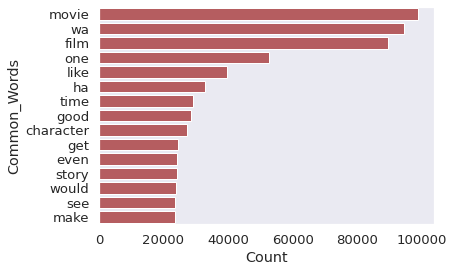

In [29]:
plotNgram(imdb_dataset.review,15,1,'Commmon Words in Text (UNIGRAM)','r')

### Bigram

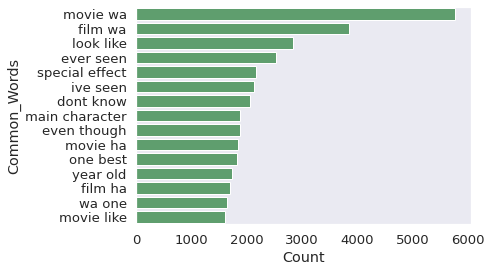

In [30]:
plotNgram(imdb_dataset.review,15,2,'Commmon Words in Text (BIGRAM)','g')

### Trigram

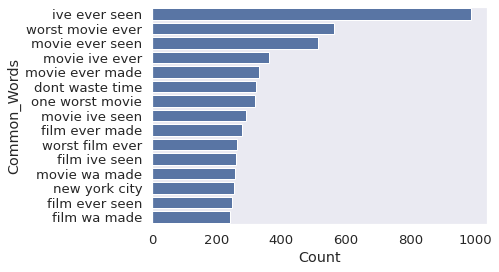

In [31]:
plotNgram(imdb_dataset.review,15,3,'Commmon Words in Text (TRIGRAM)','b')

## Training the model

### Spliting the training dataset


In [32]:
y=imdb_dataset['sentiment']
X=imdb_dataset['review']
print(f"Reviews X: \n{X}\n")
print(f"Clasification y: \n{y}")

Reviews X: 
0        one    reviewer ha mentioned   watching  1 oz ...
1         wonderful little production  filming techniqu...
2         thought  wa  wonderful way  spend time    hot...
3        basically   family   little boy jake think   z...
4        petter matteis love   time  money   visually s...
                               ...                        
49995     thought  movie    right good job  wasnt  crea...
49996    bad plot bad dialogue bad acting idiotic direc...
49997       catholic taught  parochial elementary schoo...
49998    im going    disagree   previous comment  side ...
49999     one expects  star trek movie   high art   fan...
Name: review, Length: 50000, dtype: object

Clasification y: 
0        1
1        1
2        1
3        0
4        1
        ..
49995    1
49996    0
49997    0
49998    0
49999    0
Name: sentiment, Length: 50000, dtype: int64


In [33]:
X_train, X_test, y_label, y_test = train_test_split(X, y, test_size=0.20)

## Naive Bayes Classifier

In [34]:
count_vec_NB = CountVectorizer(ngram_range=(1, 3), binary=False)
count_vec_train_NB = count_vec_NB.fit_transform(X_train)
count_vec_test_NB = count_vec_NB.transform(X_test)

In [51]:
multi_clf_count = MultinomialNB()
multi_clf_count.fit(count_vec_train_NB, y_label)

y_pred = multi_clf_count.predict(count_vec_test_NB)

In [64]:
print(f"Classification Report: \n{classification_report(y_test, y_pred,target_names=['Negative','Positive'])}\n")

Classification Report: 
              precision    recall  f1-score   support

    Negative       0.87      0.90      0.89      4934
    Positive       0.90      0.87      0.89      5066

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000




Confusion Matrix: 
[[4427  507]
 [ 642 4424]]



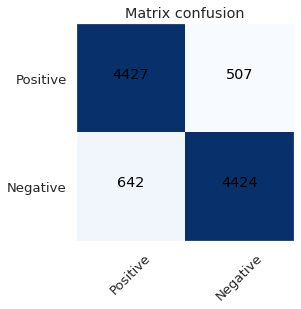

In [76]:
def plotConfusionMatrix(y_true,y_pred,title="Matrix confusion",target_names=['Positive','Negative']):
        # https://en.wikipedia.org/wiki/Confusion_matrix
        cm = confusion_matrix(y_true,y_pred)
        diag = cm.diagonal() # Píxeles clasificados correctamente para cada clase  
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title(title)
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, cm[i, j],
                         horizontalalignment="center",
                         color="black")
                
        plt.xticks([0,1], target_names, rotation=45)
        plt.yticks([0,1], target_names)
        plt.show()

#TODO:  Revisar esto
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}\n")

plotConfusionMatrix(y_test,y_pred)

In [65]:
print(f"Accuracy: \n{accuracy_score(y_test, y_pred)}")

Accuracy: 
0.8851


In [37]:
# Model persistance
###dump(multi_clf_count, 'reviews.joblib') 